In [1]:
# https://github.com/creotiv/object_detection_projects/tree/master/opencv_traffic_counting

In [2]:
# install library and download video for processing
!pip install sk-video>=1.1.8
import os
if not os.path.exists('road.mp4'):
    !wget https://learnml.s3.eu-north-1.amazonaws.com/road.mp4

Traceback (most recent call last):
  File "/home/sreerag/anaconda3/bin/pip", line 7, in <module>
    from pip._internal import main
  File "/home/sreerag/anaconda3/lib/python3.7/site-packages/pip/_internal/__init__.py", line 40, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/home/sreerag/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/autocompletion.py", line 8, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/home/sreerag/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/main_parser.py", line 11, in <module>
    from pip._internal.commands import (
  File "/home/sreerag/anaconda3/lib/python3.7/site-packages/pip/_internal/commands/__init__.py", line 6, in <module>
    from pip._internal.commands.completion import CompletionCommand
  File "/home/sreerag/anaconda3/lib/python3.7/site-packages/pip/_internal/commands/completion.py", line 6, in <module>
    from pip._internal.cli.base_command import Comman

In [28]:
# import needed modules

import os
import csv
import numpy as np
import logging
import logging.handlers
import math
import sys
import random
import numpy as np
import skvideo.io
import cv2
import matplotlib.pyplot as plt

from IPython.display import HTML
from base64 import b64encode


In [29]:
# without this some strange errors happen
# cv2.ocl.setUseOpenCL(False)
# random.seed(123)

# setup logging
def init_logging(level=logging.INFO):
    main_logger = logging.getLogger()
    for hnd in main_logger.handlers:
        main_logger.removeHandler(hnd)

    formatter = logging.Formatter(
        fmt='%(asctime)s.%(msecs)03d %(levelname)-8s [%(name)s] %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

    handler_stream = logging.StreamHandler(sys.stdout)
    handler_stream.setFormatter(formatter)
    main_logger.addHandler(handler_stream)
    main_logger.setLevel(level)

    return main_logger

Training BG Subtractor...


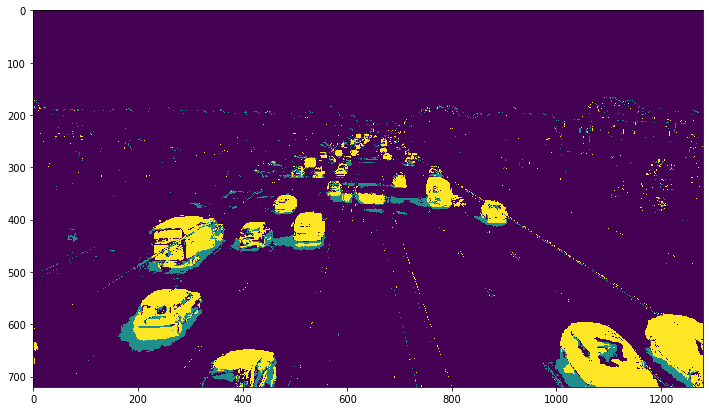

In [30]:
def train_bg_subtractor(inst, cap, num=500):
    '''
        BG substractor need process some amount of frames to start giving result
    '''
    print ('Training BG Subtractor...')
    i = 0
    for frame in cap:
        inst.apply(frame, None, 0.001)
        i += 1
        if i >= num:
            return cap

VIDEO_SOURCE = "road.mp4"

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

# Set up image source
cap = skvideo.io.vreader(VIDEO_SOURCE)

# skipping 500 frames to train bg subtractor
train_bg_subtractor(bg_subtractor, cap, num=500)

frame = next(cap)
fg_mask = bg_subtractor.apply(frame, None, 0.001)

plt.figure(figsize=(12,12))
plt.imshow(fg_mask)
plt.show()

Training BG Subtractor...


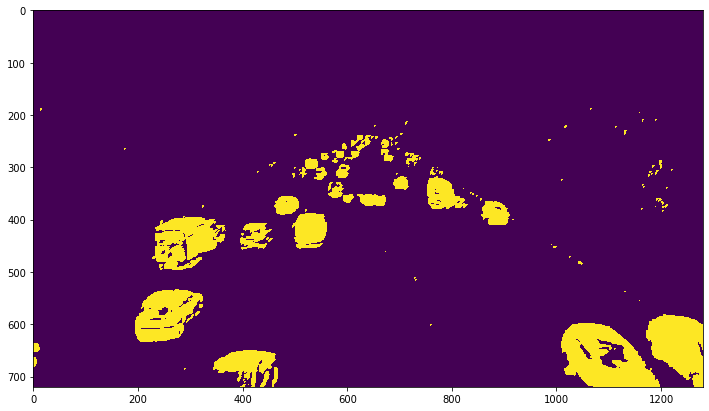

In [31]:

def filter_mask(img):
    '''
        This filters are hand-picked just based on visual tests
    '''

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

    # Fill any small holes
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    # Remove noise
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

    # Dilate to merge adjacent blobs
    dilation = cv2.dilate(opening, kernel, iterations=2)

    return dilation

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

# Set up image source
cap = skvideo.io.vreader(VIDEO_SOURCE)

# skipping 500 frames to train bg subtractor
train_bg_subtractor(bg_subtractor, cap, num=500)

frame = next(cap)
fg_mask = bg_subtractor.apply(frame, None, 0.001)
fg_mask[fg_mask < 240] = 0
fg_mask = filter_mask(fg_mask)

plt.figure(figsize=(12,12))
plt.imshow(fg_mask)
plt.show()

In [33]:
def get_centroid(x, y, w, h):
    x1 = int(w / 2)
    y1 = int(h / 2)

    cx = x + x1
    cy = y + y1

    return (cx, cy)


class ContourDetection:
    '''
        Detecting moving objects.

        Purpose of this processor is to subtrac background, get moving objects
        and detect them with a cv2.findContours method, and then filter off-by
        width and height. 

        bg_subtractor - background subtractor isinstance.
        min_contour_width - min bounding rectangle width.
        min_contour_height - min bounding rectangle height.
        save_image - if True will save detected objects mask to file.
        image_dir - where to save images(must exist).        
    '''

    def __init__(self, bg_subtractor, min_contour_width=35, min_contour_height=35, save_image=True, image_dir='ReImages'):
        super(ContourDetection, self).__init__()

        self.bg_subtractor = bg_subtractor
        self.min_contour_width = min_contour_width
        self.min_contour_height = min_contour_height
        self.save_image = save_image
        self.image_dir = image_dir

    def filter_mask(self, img, a=None):
        '''
            This filters are hand-picked just based on visual tests
        '''

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

        # Fill any small holes
        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        # Remove noise
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

        # Dilate to merge adjacent blobs
        dilation = cv2.dilate(opening, kernel, iterations=2)

        return dilation

    def detect_vehicles(self, fg_mask):

        matches = []

        # finding external contours
        contours, hierarchy = cv2.findContours(
            fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

        for (i, contour) in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            # On the exit, we add some filtering by height, width and add centroid.
            contour_valid = (w >= self.min_contour_width) and (
                h >= self.min_contour_height)

            if not contour_valid:
                continue

            centroid = get_centroid(x, y, w, h)

            matches.append(((x, y, w, h), centroid))

        return matches

    def __call__(self, frame):
        frame = frame.copy()

        fg_mask = self.bg_subtractor.apply(frame, None, 0.001)
        # just thresholding values
        fg_mask[fg_mask < 240] = 0
        fg_mask = self.filter_mask(fg_mask, 0)

        return self.detect_vehicles(fg_mask)

cd = ContourDetection(bg_subtractor)

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

# Set up image source
cap = skvideo.io.vreader(VIDEO_SOURCE)

# skipping 500 frames to train bg subtractor
train_bg_subtractor(bg_subtractor, cap, num=500)

frame = next(cap)
objects = cd(frame)

print('Getting list of [((x,y,w,h), (xc,yc)), ...]')
print(len(objects))

Training BG Subtractor...
Getting list of [((x,y,w,h), (xc,yc)), ...]
12


In [8]:
print(objects[0])

((513, 668, 49, 52), (537, 694))


In [34]:

class PipelineRunner(object):
    '''
        Very simple pipline.

        Just run passed processors in order with passing context from one to 
        another.

        You can also set log level for processors.
    '''

    def __init__(self, pipeline=None, log_level=logging.INFO):
        self.pipeline = pipeline or []
        self.context = {}
        self.log = logging.getLogger(self.__class__.__name__)
        self.log.setLevel(log_level)
        self.log_level = log_level
        self.set_log_level()

    def set_context(self, data):
        self.context = data

    def add(self, processor):
        if not isinstance(processor, PipelineProcessor):
            raise Exception(
                'Processor should be an isinstance of PipelineProcessor.')
        processor.log.setLevel(self.log_level)
        self.pipeline.append(processor)

    def remove(self, name):
        for i, p in enumerate(self.pipeline):
            if p.__class__.__name__ == name:
                del self.pipeline[i]
                return True
        return False

    def set_log_level(self):
        for p in self.pipeline:
            p.log.setLevel(self.log_level)

    def run(self):
        for p in self.pipeline:
            self.context = p(self.context)

        self.log.debug("Frame #%d processed.", self.context['frame_number'])

        return self.context


class PipelineProcessor(object):
    '''
        Base class for processors.
    '''

    def __init__(self):
        self.log = logging.getLogger(self.__class__.__name__)

In [35]:
def save_frame(frame, file_name, flip=True):
    # flip BGR to RGB
    if flip:
        cv2.imwrite(file_name, np.flip(frame, 2))
    else:
        cv2.imwrite(file_name, frame)

class ContourDetection(PipelineProcessor):
    '''
        Detecting moving objects.

        Purpose of this processor is to subtrac background, get moving objects
        and detect them with a cv2.findContours method, and then filter off-by
        width and height. 

        bg_subtractor - background subtractor isinstance.
        min_contour_width - min bounding rectangle width.
        min_contour_height - min bounding rectangle height.
        save_image - if True will save detected objects mask to file.
        image_dir - where to save images(must exist).        
    '''

    def __init__(self, bg_subtractor, min_contour_width=45, min_contour_height=45, save_image=False, image_dir='images'):
        super(ContourDetection, self).__init__()

        self.bg_subtractor = bg_subtractor
        self.min_contour_width = min_contour_width
        self.min_contour_height = min_contour_height
        self.save_image = save_image
        self.image_dir = image_dir

    def filter_mask(self, img, a=None):
        '''
            This filters are hand-picked just based on visual tests
        '''

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

        # Fill any small holes
        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        # Remove noise
        opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

        # Dilate to merge adjacent blobs
        dilation = cv2.dilate(opening, kernel, iterations=2)

        return dilation

    def detect_vehicles(self, fg_mask, context):

        matches = []

        # finding external contours
        contours, hierarchy = cv2.findContours(
            fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)

        for (i, contour) in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            contour_valid = (w >= self.min_contour_width) and (
                h >= self.min_contour_height)

            if not contour_valid:
                continue

            centroid = get_centroid(x, y, w, h)

            matches.append(((x, y, w, h), centroid))

        return matches

    def __call__(self, context):
        frame = context['frame'].copy()
        frame_number = context['frame_number']

        fg_mask = self.bg_subtractor.apply(frame, None, 0.001)
        # just thresholding values
        fg_mask[fg_mask < 240] = 0
        fg_mask = self.filter_mask(fg_mask, frame_number)

        if self.save_image:
            save_frame(fg_mask, self.image_dir +
                             "/mask_%04d.png" % frame_number, flip=False)

        context['objects'] = self.detect_vehicles(fg_mask, context)
        context['fg_mask'] = fg_mask

        return context


In [36]:
def distance(x, y, type='euclidian', x_weight=1.0, y_weight=1.0):
    if type == 'euclidian':
        return math.sqrt(float((x[0] - y[0])**2) / x_weight + float((x[1] - y[1])**2) / y_weight)


class VehicleCounter(PipelineProcessor):
    '''
        Counting vehicles that entered in exit zone.

        Purpose of this class based on detected object and local cache create
        objects pathes and count that entered in exit zone defined by exit masks.

        exit_masks - list of the exit masks.
        path_size - max number of points in a path.
        max_dst - max distance between two points.
    '''

    def __init__(self, exit_masks=[], path_size=10, max_dst=30, x_weight=1.0, y_weight=1.0):
        super(VehicleCounter, self).__init__()

        self.exit_masks = exit_masks

        self.vehicle_count = 0
        self.path_size = path_size
        self.pathes = []
        self.max_dst = max_dst
        self.x_weight = x_weight
        self.y_weight = y_weight

    def check_exit(self, point):
        for exit_mask in self.exit_masks:
            try:
                if exit_mask[point[1]][point[0]] == 255:
                    return True
            except:
                return True
        return False

    def __call__(self, context):
        objects = context['objects']
        context['exit_masks'] = self.exit_masks
        context['pathes'] = self.pathes
        context['vehicle_count'] = self.vehicle_count
        if not objects:
            return context

        points = np.array(objects)[:, 0:2]
        points = points.tolist()

        # add new points if pathes is empty
        if not self.pathes:
            for match in points:
                self.pathes.append([match])

        else:
            # link new points with old pathes based on minimum distance between
            # points
            new_pathes = []

            for path in self.pathes:
                _min = 999999
                _match = None
                for p in points:
                    if len(path) == 1:
                        # distance from last point to current
                        d = distance(p[0], path[-1][0])
                    else:
                        # based on 2 prev points predict next point and calculate
                        # distance from predicted next point to current
                        xn = 2 * path[-1][0][0] - path[-2][0][0]
                        yn = 2 * path[-1][0][1] - path[-2][0][1]
                        d = distance(
                            p[0], (xn, yn),
                            x_weight=self.x_weight,
                            y_weight=self.y_weight
                        )

                    if d < _min:
                        _min = d
                        _match = p

                if _match and _min <= self.max_dst:
                    points.remove(_match)
                    path.append(_match)
                    new_pathes.append(path)

                # do not drop path if current frame has no matches
                if _match is None:
                    new_pathes.append(path)

            self.pathes = new_pathes

            # add new pathes
            if len(points):
                for p in points:
                    # do not add points that already should be counted
                    if self.check_exit(p[1]):
                        continue
                    self.pathes.append([p])

        # save only last N points in path
        for i, _ in enumerate(self.pathes):
            self.pathes[i] = self.pathes[i][self.path_size * -1:]

        # count vehicles and drop counted pathes:
        new_pathes = []
        for i, path in enumerate(self.pathes):
            d = path[-2:]

            if (
                # need at list two points to count
                len(d) >= 2 and
                # prev point not in exit zone
                not self.check_exit(d[0][1]) and
                # current point in exit zone
                self.check_exit(d[1][1]) and
                # path len is bigger then min
                self.path_size <= len(path)
            ):
                self.vehicle_count += 1
            else:
                # prevent linking with path that already in exit zone
                add = True
                for p in path:
                    if self.check_exit(p[1]):
                        add = False
                        break
                if add:
                    new_pathes.append(path)

        self.pathes = new_pathes

        context['pathes'] = self.pathes
        context['objects'] = objects
        context['vehicle_count'] = self.vehicle_count

        self.log.debug('#VEHICLES FOUND: %s' % self.vehicle_count)

        return context



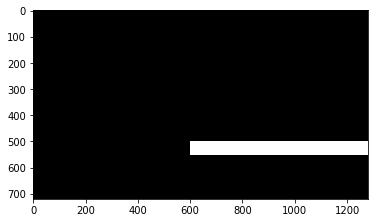

In [37]:
EXIT_PTS = np.array([
    [[600, 500], [600, 550], [1280, 550], [1280, 500]],
    [[100, 0], [0, 0], [00, 00], [100, 0]]
])
SHAPE = (720,1280)
base = np.zeros(SHAPE + (3,), dtype='uint8')
exit_mask = cv2.fillPoly(base, EXIT_PTS, (255, 255, 255))[:, :, 0]

plt.imshow(base)
plt.show()

In [38]:
class CsvWriter(PipelineProcessor):

    def __init__(self, path, name, start_time=0, fps=15):
        super(CsvWriter, self).__init__()

        self.fp = open(os.path.join(path, name), 'w')
        self.writer = csv.DictWriter(self.fp, fieldnames=['time', 'vehicles'])
        self.writer.writeheader()
        self.start_time = start_time
        self.fps = fps
        self.path = path
        self.name = name
        self.prev = None

    def __call__(self, context):
        frame_number = context['frame_number']
        count = _count = context['vehicle_count']

        if self.prev:
            _count = count - self.prev

        time = ((self.start_time + int(frame_number / self.fps)) * 100 
                + int(100.0 / self.fps) * (frame_number % self.fps))
        self.writer.writerow({'time': time, 'vehicles': _count})
        self.prev = count

        return context

BOUNDING_BOX_COLOUR = (255, 192, 0)
CENTROID_COLOUR = (255, 192, 0)
CAR_COLOURS = [(255, 192, 0)]
EXIT_COLOR = (66, 183, 42)

class Visualizer(PipelineProcessor):

    def __init__(self, save_image=True, image_dir='images'):
        super(Visualizer, self).__init__()

        self.save_image = save_image
        self.image_dir = image_dir

    def check_exit(self, point, exit_masks=[]):
        for exit_mask in exit_masks:
            if exit_mask[point[1]][point[0]] == 255:
                return True
        return False

    def draw_pathes(self, img, pathes):
        if not img.any():
            return

        for i, path in enumerate(pathes):
            path = np.array(path)[:, 1].tolist()
            for point in path:
                cv2.circle(img, point, 2, CAR_COLOURS[0], -1)
                cv2.polylines(img, [np.int32(path)], False, CAR_COLOURS[0], 1)

        return img

    def draw_boxes(self, img, pathes, exit_masks=[]):
        for (i, match) in enumerate(pathes):

            contour, centroid = match[-1][:2]
            if self.check_exit(centroid, exit_masks):
                continue

            x, y, w, h = contour

            cv2.rectangle(img, (x, y), (x + w - 1, y + h - 1),
                          BOUNDING_BOX_COLOUR, 1)
            cv2.circle(img, centroid, 2, CENTROID_COLOUR, -1)

        return img

    def draw_ui(self, img, vehicle_count, exit_masks=[]):

        # this just add green mask with opacity to the image
        for exit_mask in exit_masks:
            _img = np.zeros(img.shape, img.dtype)
            _img[:, :] = EXIT_COLOR
            mask = cv2.bitwise_and(_img, _img, mask=exit_mask)
            cv2.addWeighted(mask, 1, img, 1, 0, img)

        # drawing top block with counts
        cv2.rectangle(img, (0, 0), (img.shape[1], 50), (0, 0, 0), cv2.FILLED)
        cv2.putText(img, ("Vehicles passed: {total} ".format(total=vehicle_count)), (30, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
        return img

    def __call__(self, context):
        frame = context['frame'].copy()
        frame = np.ascontiguousarray(np.flip(frame, 2))
        frame_number = context['frame_number']
        pathes = context['pathes']
        exit_masks = context['exit_masks']
        vehicle_count = context['vehicle_count']

        frame = self.draw_ui(frame, vehicle_count, exit_masks)
        frame = self.draw_pathes(frame, pathes)
        frame = self.draw_boxes(frame, pathes, exit_masks)
        if self.save_image:
            save_frame(frame, self.image_dir +
                            "/processed_%04d.png" % frame_number)

        context['frame'] = frame
        return context

In [40]:
def distance(x, y, type='euclidian', x_weight=1.0, y_weight=1.0):
    if type == 'euclidian':
        return math.sqrt(float((x[0] - y[0])**2) / x_weight + float((x[1] - y[1])**2) / y_weight)


class VehicleCounter(PipelineProcessor):
    '''
        Counting vehicles that entered in exit zone.

        Purpose of this class based on detected object and local cache create
        objects pathes and count that entered in exit zone defined by exit masks.

        exit_masks - list of the exit masks.
        path_size - max number of points in a path.
        max_dst - max distance between two points.
    '''

    def __init__(self, exit_masks=[], path_size=10, max_dst=30, x_weight=1.0, y_weight=1.0):
        super(VehicleCounter, self).__init__()

        self.exit_masks = exit_masks

        self.vehicle_count = 0
        self.path_size = path_size
        self.pathes = []
        self.max_dst = max_dst
        self.x_weight = x_weight
        self.y_weight = y_weight

    def check_exit(self, point):
        for exit_mask in self.exit_masks:
            try:
                if exit_mask[point[1]][point[0]] == 255:
                    return True
            except:
                return True
        return False

    def __call__(self, context):
        objects = context['objects']
        context['exit_masks'] = self.exit_masks
        context['pathes'] = self.pathes
        context['vehicle_count'] = self.vehicle_count
        if not objects:
            return context

        points = np.array(objects)[:, 0:2]
        points = points.tolist()

        # add new points if pathes is empty
        if not self.pathes:
            for match in points:
                self.pathes.append([match])

        else:
            # link new points with old pathes based on minimum distance between
            # points
            new_pathes = []

            for path in self.pathes:
                _min = 999999
                _match = None
                for p in points:
                    if len(path) == 1:
                        # distance from last point to current
                        d = distance(p[0], path[-1][0])
                    else:
                        # based on 2 prev points predict next point and calculate
                        # distance from predicted next point to current
                        xn = 2 * path[-1][0][0] - path[-2][0][0]
                        yn = 2 * path[-1][0][1] - path[-2][0][1]
                        d = distance(
                            p[0], (xn, yn),
                            x_weight=self.x_weight,
                            y_weight=self.y_weight
                        )

                    if d < _min:
                        _min = d
                        _match = p

                if _match and _min <= self.max_dst:
                    points.remove(_match)
                    path.append(_match)
                    new_pathes.append(path)

                # do not drop path if current frame has no matches
                if _match is None:
                    new_pathes.append(path)

            self.pathes = new_pathes

            # add new pathes
            if len(points):
                for p in points:
                    # do not add points that already should be counted
                    if self.check_exit(p[1]):
                        continue
                    self.pathes.append([p])

        # save only last N points in path
        for i, _ in enumerate(self.pathes):
            self.pathes[i] = self.pathes[i][self.path_size * -1:]

        # count vehicles and drop counted pathes:
        new_pathes = []
        for i, path in enumerate(self.pathes):
            d = path[-2:]

            if (
                # need at list two points to count
                len(d) >= 2 and
                # prev point not in exit zone
                not self.check_exit(d[0][1]) and
                # current point in exit zone
                self.check_exit(d[1][1]) and
                # path len is bigger then min
                self.path_size <= len(path)
            ):
                self.vehicle_count += 1
            else:
                # prevent linking with path that already in exit zone
                add = True
                for p in path:
                    if self.check_exit(p[1]):
                        add = False
                        break
                if add:
                    new_pathes.append(path)

        self.pathes = new_pathes

        context['pathes'] = self.pathes
        context['objects'] = objects
        context['vehicle_count'] = self.vehicle_count

        self.log.debug('#VEHICLES FOUND: %s' % self.vehicle_count)

        return context

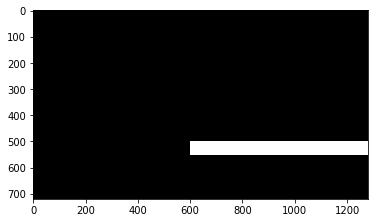

In [41]:
EXIT_PTS = np.array([
    [[600, 500], [600, 550], [1280, 550], [1280, 500]],
    [[100, 0], [0, 0], [00, 00], [100, 0]]
])
SHAPE = (720,1280)
base = np.zeros(SHAPE + (3,), dtype='uint8')
exit_mask = cv2.fillPoly(base, EXIT_PTS, (255, 255, 255))[:, :, 0]

plt.imshow(base)
plt.show()

In [42]:
import pymysql

connection = pymysql.connect(host="localhost",port=3307, user="root", passwd="", database="Traffic")
cursor = connection.cursor()

In [45]:
class CsvWriter(PipelineProcessor):

    def __init__(self, path, name, start_time=0, fps=15):
        super(CsvWriter, self).__init__()

        self.fp = open(os.path.join(path, name), 'w')
        self.writer = csv.DictWriter(self.fp, fieldnames=['time', 'vehicles'])
        self.writer.writeheader()
        self.start_time = start_time
        self.fps = fps
        self.path = path
        self.name = name
        self.prev = None

    def __call__(self, context):
        frame_number = context['frame_number']
        count = _count = context['vehicle_count']
        print(count)
        print(frame_number)
        if(frame_number != 0):
            sql="INSERT INTO VehicleInTheRegion (TrafficIn) VALUES( %s );"
            val=(count)
            cursor.execute(sql,val)
            connection.commit()
            cursor.execute("UPDATE VehicleInTheRegion SET Frame = %s ORDER BY id DESC LIMIT 1",(frame_number))
            connection.commit()
            
        if self.prev:
            _count = count - self.prev

        time = 1000
        self.writer.writerow({'time': time, 'vehicles': _count})
        self.prev = count
        
        

        return context

BOUNDING_BOX_COLOUR = (255, 192, 0)
CENTROID_COLOUR = (255, 192, 0)
CAR_COLOURS = [(255, 192, 0)]
EXIT_COLOR = (66, 183, 42)

class Visualizer(PipelineProcessor):

    def __init__(self, save_image=True, image_dir='images'):
        super(Visualizer, self).__init__()

        self.save_image = save_image
        self.image_dir = image_dir

    def check_exit(self, point, exit_masks=[]):
        for exit_mask in exit_masks:
            if exit_mask[point[1]][point[0]] == 255:
                return True
        return False

    def draw_pathes(self, img, pathes):
        if not img.any():
            return

        for i, path in enumerate(pathes):
            path = np.array(path)[:, 1].tolist()
            for point in path:
                cv2.circle(img, point, 2, CAR_COLOURS[0], -1)
                cv2.polylines(img, [np.int32(path)], False, CAR_COLOURS[0], 1)

        return img

    def draw_boxes(self, img, pathes, exit_masks=[]):
        for (i, match) in enumerate(pathes):

            contour, centroid = match[-1][:2]
            if self.check_exit(centroid, exit_masks):
                continue

            x, y, w, h = contour

            cv2.rectangle(img, (x, y), (x + w - 1, y + h - 1),
                          BOUNDING_BOX_COLOUR, 1)
            cv2.circle(img, centroid, 2, CENTROID_COLOUR, -1)

        return img

    def draw_ui(self, img, vehicle_count, exit_masks=[]):

        # this just add green mask with opacity to the image
        for exit_mask in exit_masks:
            _img = np.zeros(img.shape, img.dtype)
            _img[:, :] = EXIT_COLOR
            mask = cv2.bitwise_and(_img, _img, mask=exit_mask)
            cv2.addWeighted(mask, 1, img, 1, 0, img)

        # drawing top block with counts
        cv2.rectangle(img, (0, 0), (img.shape[1], 50), (0, 0, 0), cv2.FILLED)
        cv2.putText(img, ("Vehicles passed: {total} ".format(total=vehicle_count)), (30, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
        return img

    def __call__(self, context):
        frame = context['frame'].copy()
        frame = np.ascontiguousarray(np.flip(frame, 2))
        frame_number = context['frame_number']
        pathes = context['pathes']
        exit_masks = context['exit_masks']
        vehicle_count = context['vehicle_count']

        frame = self.draw_ui(frame, vehicle_count, exit_masks)
        frame = self.draw_pathes(frame, pathes)
        frame = self.draw_boxes(frame, pathes, exit_masks)
        if self.save_image:
            save_frame(frame, self.image_dir +
                            "/processed_%04d.png" % frame_number)

        context['frame'] = frame
        return context

In [46]:
# build runner
def main():
    log = logging.getLogger("main")

    # creating exit mask from points, where we will be counting our vehicles
    base = np.zeros(SHAPE + (3,), dtype='uint8')
    exit_mask = cv2.fillPoly(base, EXIT_PTS, (255, 255, 255))[:, :, 0]

    # there is also bgslibrary, that seems to give better BG substruction, but
    # not tested it yet
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=500, detectShadows=True)

    # processing pipline for programming conviniance
    pipeline = PipelineRunner(pipeline=[
        ContourDetection(bg_subtractor=bg_subtractor,
                         save_image=True, image_dir=IMAGE_DIR),
        # we use y_weight == 2.0 because traffic are moving vertically on video
        # use x_weight == 2.0 for horizontal.
        VehicleCounter(exit_masks=[exit_mask], y_weight=2.0),
        Visualizer(image_dir=IMAGE_DIR,save_image=False),
        CsvWriter(path='./', name='report.csv')
    ], log_level=logging.INFO)

    # Set up image source
    cap = skvideo.io.vreader(VIDEO_SOURCE)

    # skipping 500 frames to train bg subtractor
    train_bg_subtractor(bg_subtractor, cap, num=500)

    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    writer = cv2.VideoWriter(VIDEO_OUT, fourcc, 25, (SHAPE[1], SHAPE[0]), True)

    frame_number = -1
    for frame in cap:
        if not frame.any():
            log.error("Frame capture failed, stopping...")
            break

        frame_number += 1
        log.info("Frame #%s" % frame_number)

        pipeline.set_context({
            'frame': frame,
            'frame_number': frame_number,
        })
        ctx = pipeline.run()
        writer.write(ctx['frame'])

        if frame_number > PARSE_FRAMES:
            break
    writer.release()

In [50]:
# Parameters
# ============================================================================
IMAGE_DIR = "./out"
VIDEO_SOURCE = "road.mp4"
VIDEO_OUT = "road_parsedIn.mp4"
PARSE_FRAMES = 15*25
SHAPE = (720, 1280)  # HxW
EXIT_PTS = np.array([
    [[600, 500], [600, 550], [1280, 550], [1280, 500]],
    [[100, 0], [0, 0], [00, 00], [100, 0]]
])
# ============================================================================

log = init_logging()
main()

Training BG Subtractor...
2020-02-15 12:08:58.849 INFO     [main] Frame #0
0
0
2020-02-15 12:08:58.913 INFO     [main] Frame #1
0
1
2020-02-15 12:08:59.068 INFO     [main] Frame #2
0
2
2020-02-15 12:08:59.324 INFO     [main] Frame #3
0
3
2020-02-15 12:08:59.506 INFO     [main] Frame #4
0
4
2020-02-15 12:08:59.661 INFO     [main] Frame #5
0
5
2020-02-15 12:08:59.764 INFO     [main] Frame #6
0
6
2020-02-15 12:09:00.003 INFO     [main] Frame #7
0
7
2020-02-15 12:09:00.150 INFO     [main] Frame #8
0
8
2020-02-15 12:09:00.284 INFO     [main] Frame #9
0
9
2020-02-15 12:09:00.385 INFO     [main] Frame #10
0
10
2020-02-15 12:09:00.502 INFO     [main] Frame #11
0
11
2020-02-15 12:09:00.697 INFO     [main] Frame #12
0
12
2020-02-15 12:09:00.868 INFO     [main] Frame #13
0
13
2020-02-15 12:09:00.964 INFO     [main] Frame #14
0
14
2020-02-15 12:09:01.075 INFO     [main] Frame #15
0
15
2020-02-15 12:09:01.197 INFO     [main] Frame #16
0
16
2020-02-15 12:09:01.354 INFO     [main] Frame #17
0
17
2020